# Import Section
Before run the code we must import some library that needed to solve the problems. Pandas to manage data from file, numpy to manage data in array, matplotlib to visualization our data, and zscore to help in finding anomaly with Z-score

In [1]:
import pandas as pd
#import numpy as np
import matplotlib.pyplot as plt
#from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import zscore

# Load data
Load data from github with url and pandas library

In [2]:
# Load the dataset
url = 'https://raw.githubusercontent.com/hafidzwibowo/ntx-de-technical-test/main/Soal%201%20-%20Data%20Transformation%20dan%20Analysis%20Case/ecommerce-session-bigquery.csv'
df = pd.read_csv(url, sep=',', engine='python')

In [3]:
# Display the first few rows of the dataframe
print(df.head())


         fullVisitorId channelGrouping     time        country  \
0  2515546493837534633  Organic Search   966564         Taiwan   
1  9361741997835388618  Organic Search   157377         France   
2  7313828956068851679        Referral   228279  United States   
3  6036794406403793540  Organic Search  1615618  United States   
4  7847280609739507227  Organic Search    37832         Canada   

                            city  totalTransactionRevenue  transactions  \
0                      (not set)                      NaN           NaN   
1  not available in demo dataset                      NaN           NaN   
2                  San Francisco                      NaN           NaN   
3                        Boulder                      NaN           NaN   
4  not available in demo dataset                      NaN           NaN   

   timeOnSite  pageviews  sessionQualityDim  ...  itemQuantity  itemRevenue  \
0      1567.0       82.0               17.0  ...           NaN          N

# Convert date time
To make it easy to find a day in this data we have ti convert our date column from array to datetime

In [4]:
# Convert date column to datetime
df['DateTime'] = pd.to_datetime(df['date'].astype(str), format='%Y%m%d')

#df['date'] = pd.to_datetime(df['visitStartTime'], unit='s')


In [5]:
df['DateTime']

0      2017-07-21
1      2017-04-13
2      2017-07-27
3      2017-07-31
4      2017-07-28
          ...    
9995   2016-08-09
9996   2016-10-05
9997   2016-09-01
9998   2016-09-29
9999   2016-09-04
Name: DateTime, Length: 10000, dtype: datetime64[ns]

# 1. Identify top products based on the total transaction revenue per day
To identify top products based on the total transaction revenue per day we have to make sure that transaction revenue don't have any na array so we have to fill it with 0. After that, group data by datetime column and product SKU with focusing in total transaction revenue. To find top products daily we sort data by transaction revenue in descending that group by datetime. because we get 0 in every product transaction revenue form data so the result is can't be seen.

In [6]:

df['transactionRevenue'] = df['transactionRevenue'].fillna(0)
daily_revenue = df.groupby([df['DateTime'].dt.date, 'productSKU'])['transactionRevenue'].sum().reset_index()
top_products_daily = daily_revenue.sort_values(by='transactionRevenue', ascending=False).groupby('DateTime').head(5)
print(top_products_daily)

        DateTime      productSKU  transactionRevenue
0     2016-08-01  GGOEAKDH019899                 0.0
800   2016-09-25  GGOEGBJR018199                 0.0
780   2016-09-24  GGOEGBMC056599                 0.0
779   2016-09-24  GGOEGBMB073799                 0.0
778   2016-09-24  GGOEGBJR018199                 0.0
...          ...             ...                 ...
391   2016-09-01  GGOEGBJC019999                 0.0
397   2016-09-01  GGOEGCKQ013199                 0.0
396   2016-09-01  GGOEGBMJ013399                 0.0
395   2016-09-01  GGOEGBMC056599                 0.0
1163  2017-08-01         9181573                 0.0

[425 rows x 3 columns]


# 2. Detect anomalies in the number of transactions for a specific product
To detect anomalies in the number of transactions for a spesific product we use Z-Score. First, we count the number of transactions for each product over time by grouping datetime, productSKU, and transactions.

In [7]:
# Aggregating the number of transactions for each product over time
product_transactions = df.groupby([df['DateTime'].dt.date, 'productSKU'])['transactions'].sum().reset_index()


After that we detect anomalies using Z-Score. In this section we transform product transactions by grouping with each of their Z-Score. We count product transactions that is anomalies by count their Z-Score where if the Z-Score is uo to 3 or less than -3. We found 14 anomalies in this dataset

In [10]:
# Detect anomalies using z-score
product_transactions['zscore'] = product_transactions.groupby('productSKU')['transactions'].transform(lambda x: zscore(x, ddof=1))
anomalies = product_transactions[(product_transactions['zscore'] > 3) | (product_transactions['zscore'] < -3)]
print(anomalies)


       DateTime      productSKU  transactions    zscore
89   2016-08-07  GGOEGFKQ020399           1.0  3.614784
208  2016-08-17  GGOEGBFC018799           4.0  3.618694
316  2016-08-25  GGOEGBMJ013399           6.0  5.712779
321  2016-08-26  GGOEGBJC014399           6.0  4.160756
322  2016-08-26  GGOEGBJC019999           7.0  4.782444
358  2016-08-29  GGOEGBJC014399           5.0  3.352381
363  2016-08-29  GGOEGBMC056599           5.0  3.417707
394  2016-09-01  GGOEGBMB073799           4.0  3.522875
452  2016-09-06  GGOEGBJB022599           2.0  3.171329
579  2016-09-16    GGOEGAAX0037           4.0  3.392615
596  2016-09-16  GGOEGCKQ013199           5.0  4.310075
600  2016-09-16  GGOEGFSR022099           3.0  3.728814
804  2016-09-25  GGOEGCBQ016499           3.0  3.146603
952  2016-10-02    GGOEGAAX0168           2.0  3.181126


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


# 3. Identify the most profitable city or province
To identify the most profitable city or province we first group city with transaction revenue and descending and for province because in dataset we just have country so we use country column to group by transaction revenue descending ti find province revenue. most profitable city and province we get the number one in dataset.

In [11]:
city_revenue = df.groupby('city')['transactionRevenue'].sum().reset_index().sort_values(by='transactionRevenue', ascending=False)
province_revenue = df.groupby('country')['transactionRevenue'].sum().reset_index().sort_values(by='transactionRevenue', ascending=False)

most_profitable_city = city_revenue.iloc[1]
most_profitable_province = province_revenue.iloc[1]

print(f"Most Profitable City: {most_profitable_city}")
print(f"Most Profitable Province: {most_profitable_province}")

Most Profitable City: city                  Pittsburgh
transactionRevenue           0.0
Name: 117, dtype: object
Most Profitable Province: country               Romania
transactionRevenue        0.0
Name: 79, dtype: object


# Visualization data
First we plot top products based on total transaction revenue per day by use pivot with index DateTime columns Product SKU and transaction revenue for values and if there's na in every column then we fill 0.

<ipython-input-12-c66ee39f9365>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


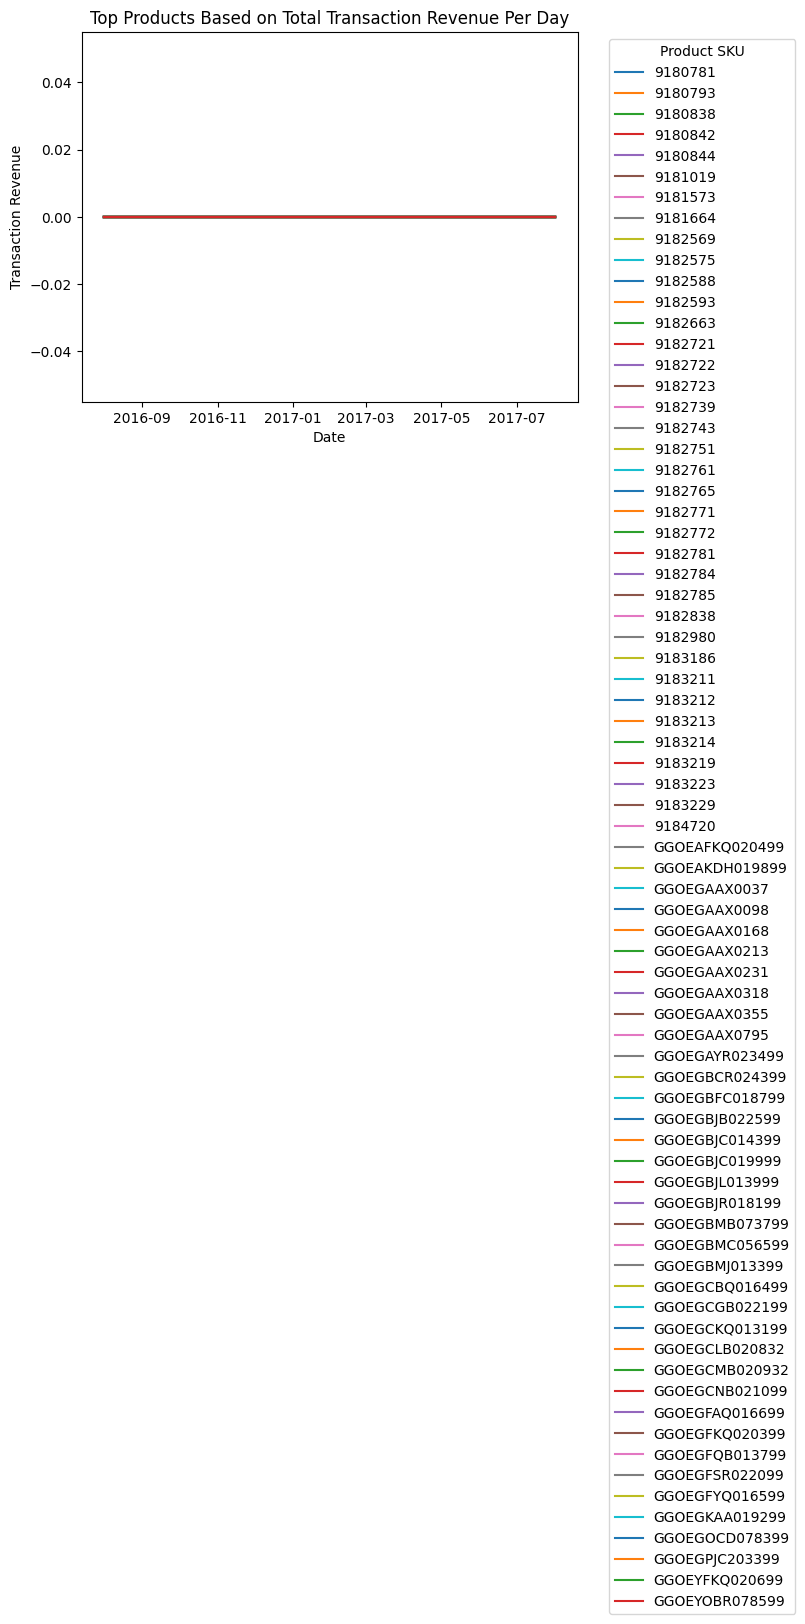

In [12]:
# Plotting top products based on total transaction revenue per day
top_products_pivot = top_products_daily.pivot(index='DateTime', columns='productSKU', values='transactionRevenue').fillna(0)
top_products_pivot.plot(ax=plt.gca(), title='Top Products Based on Total Transaction Revenue Per Day')
plt.xlabel('Date')
plt.ylabel('Transaction Revenue')
plt.legend(title='Product SKU', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


Then we plot transaction anomalies to every product SKU so we can see the details to every anomalies in this dataset

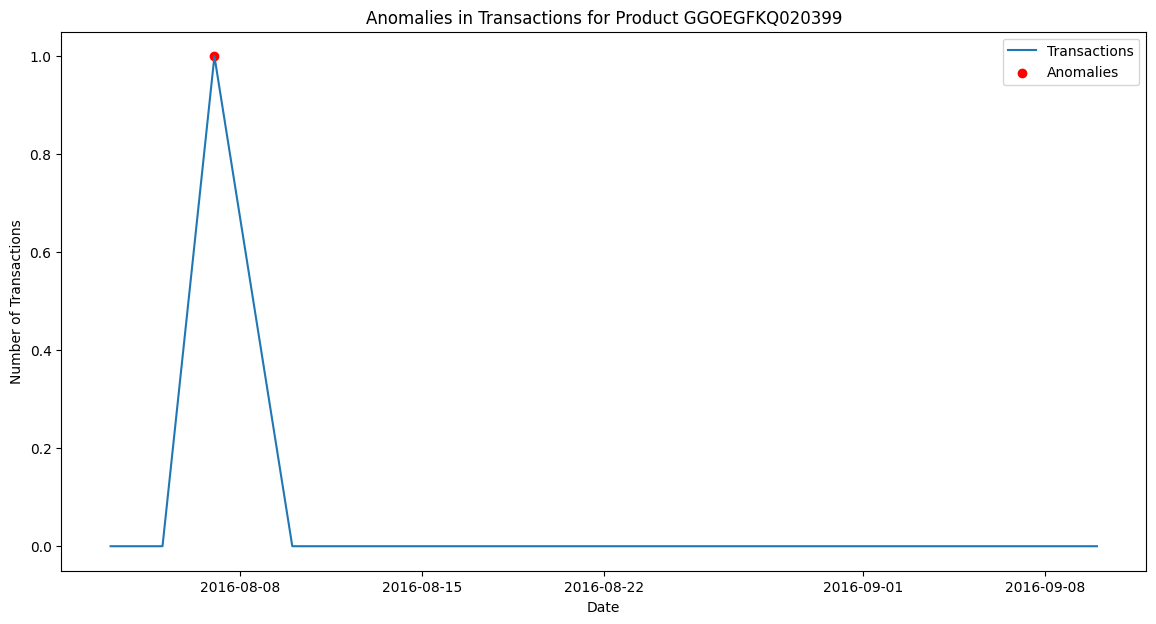

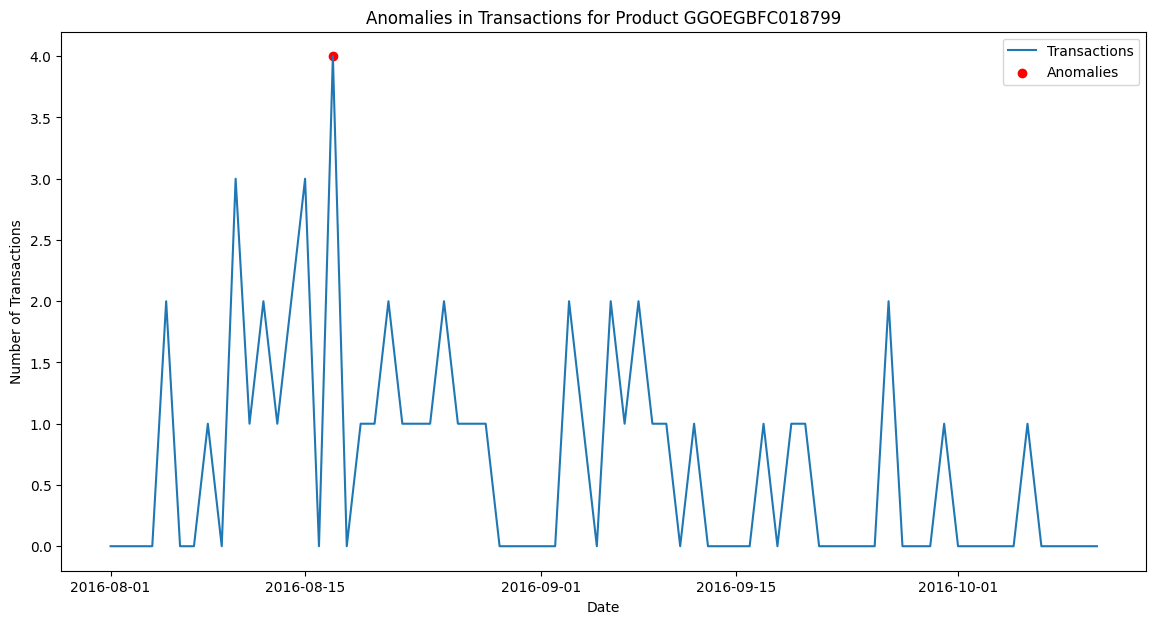

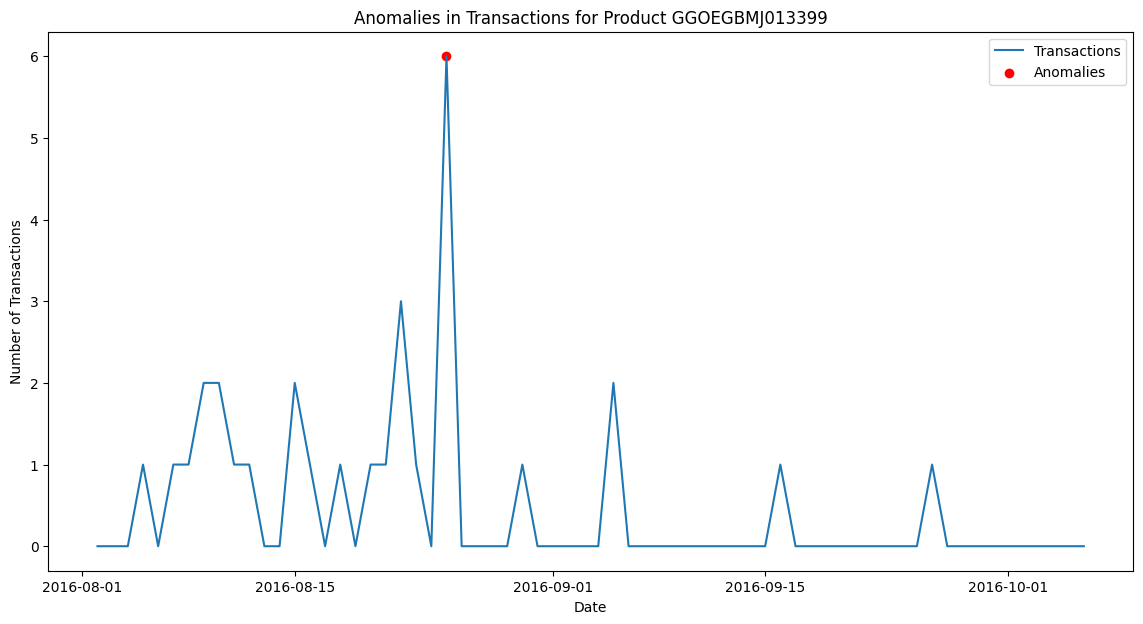

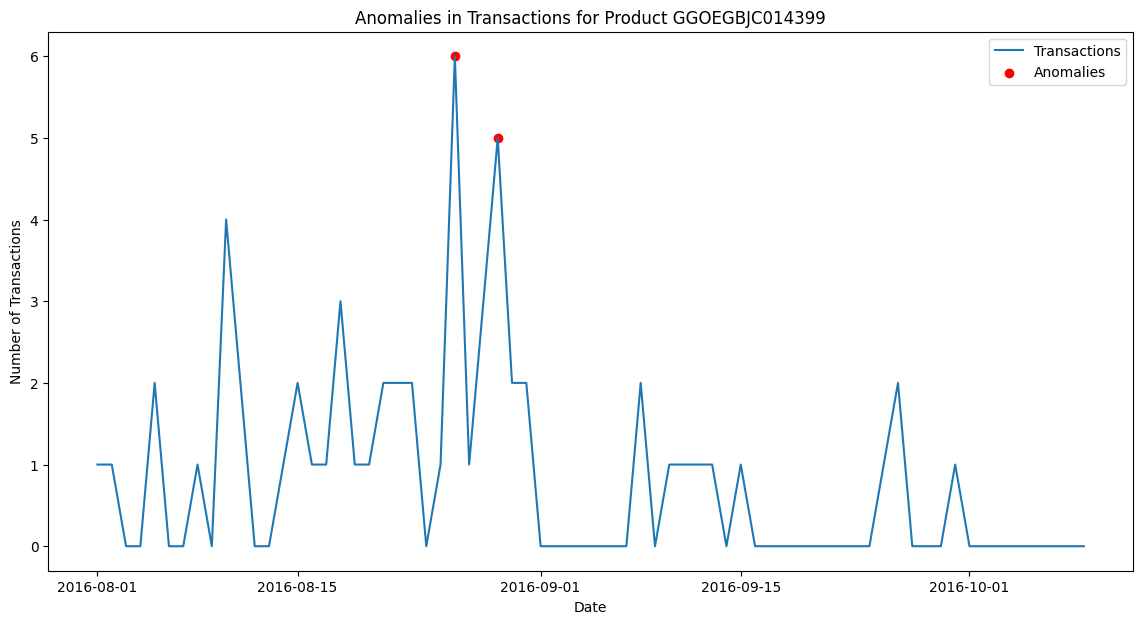

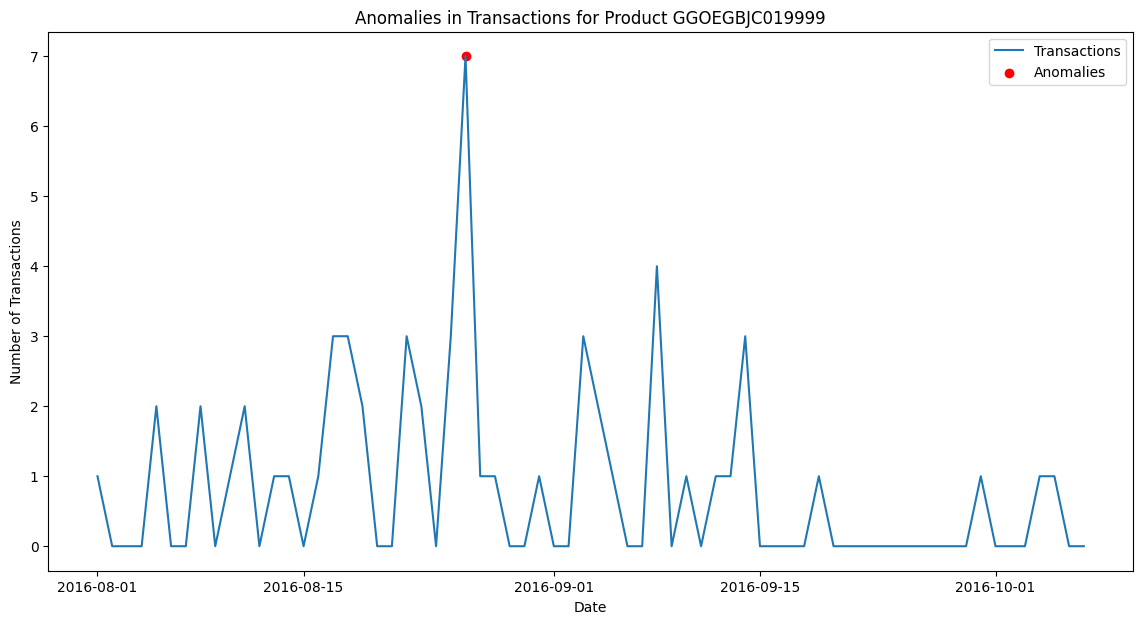

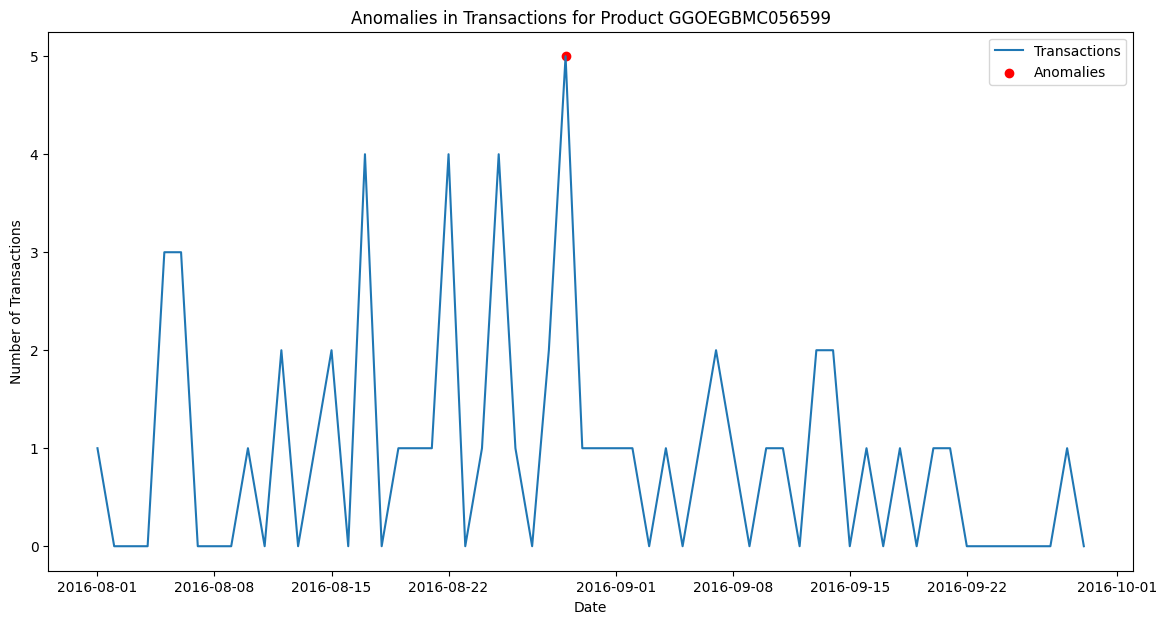

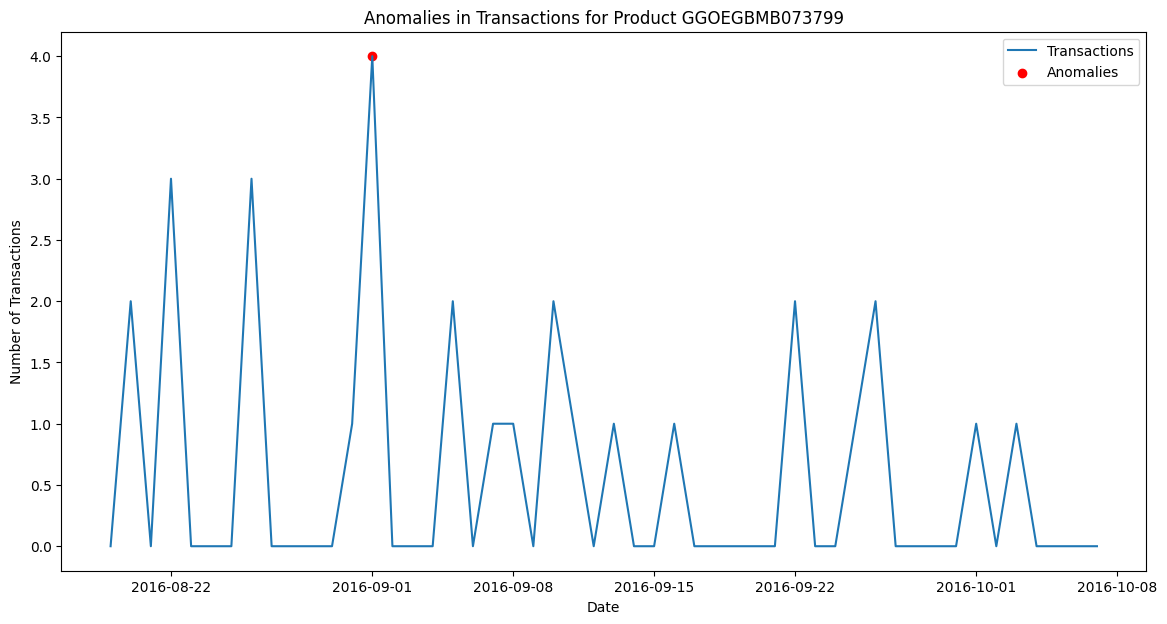

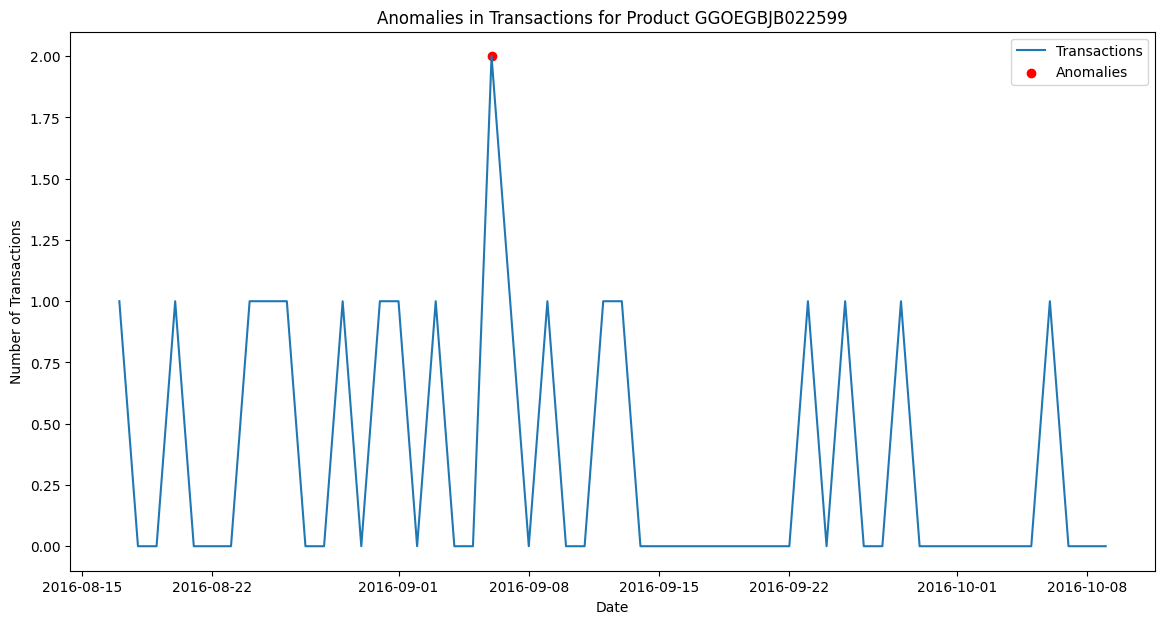

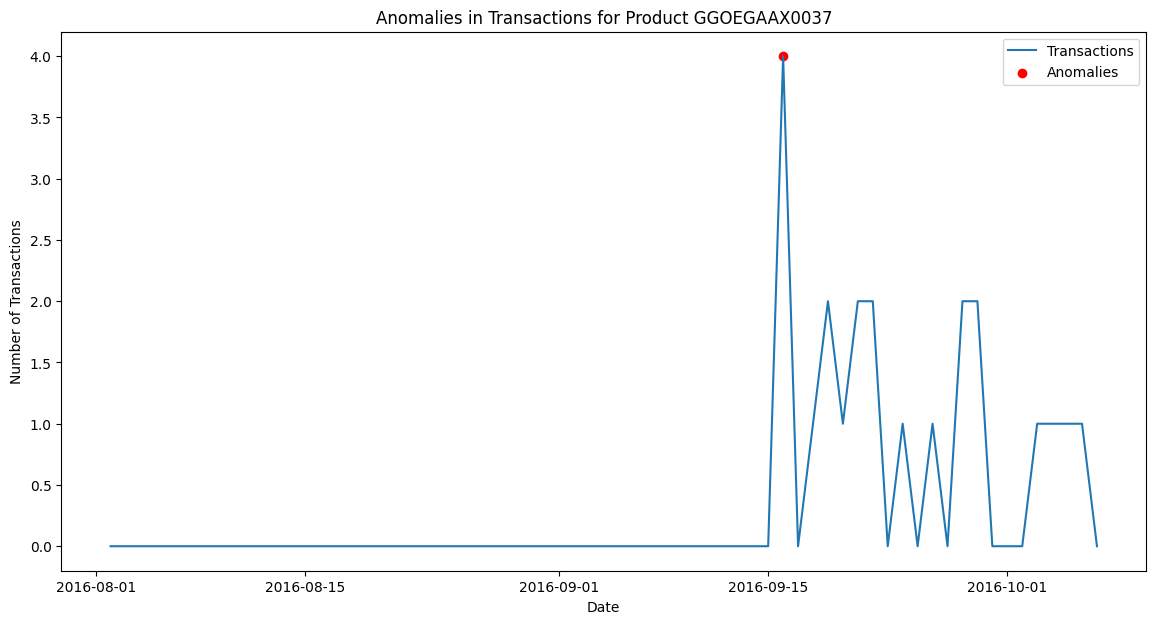

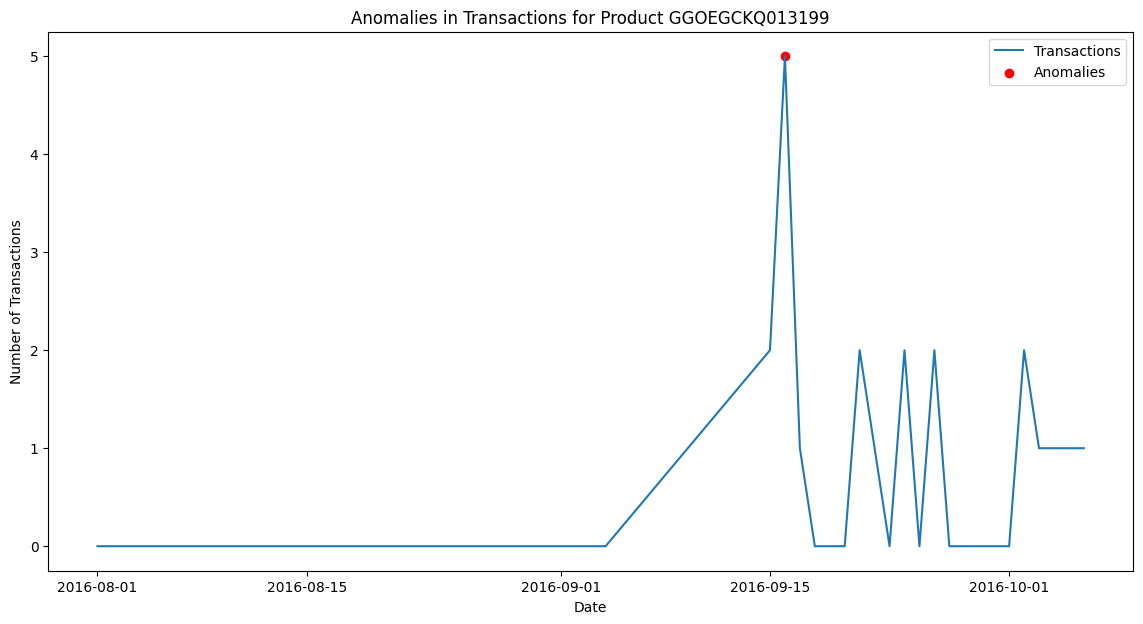

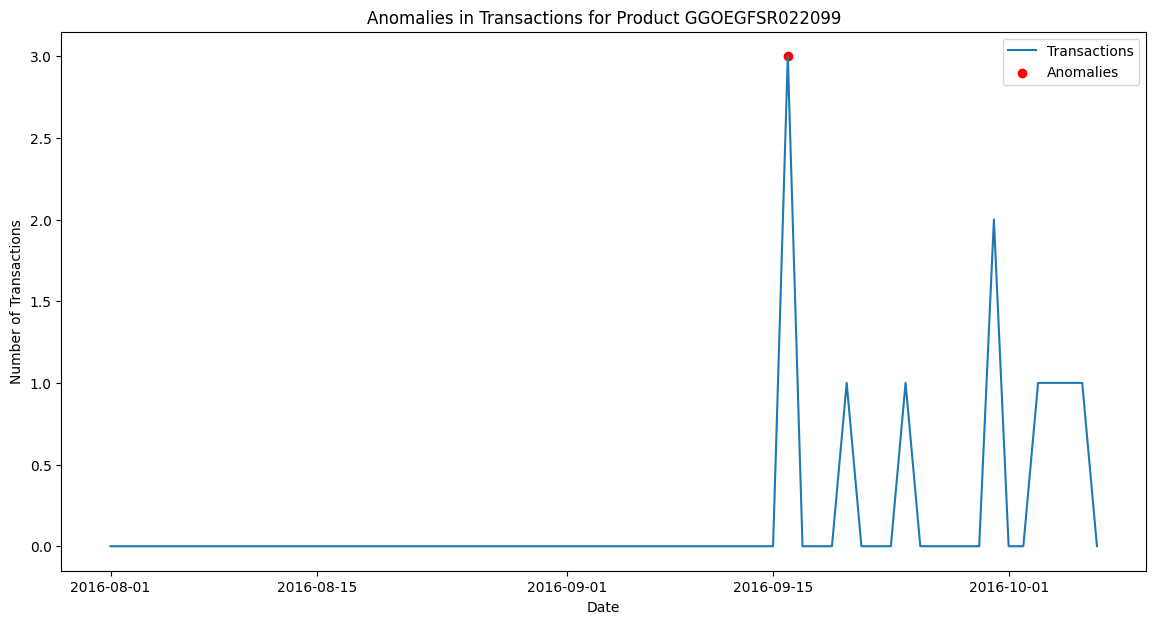

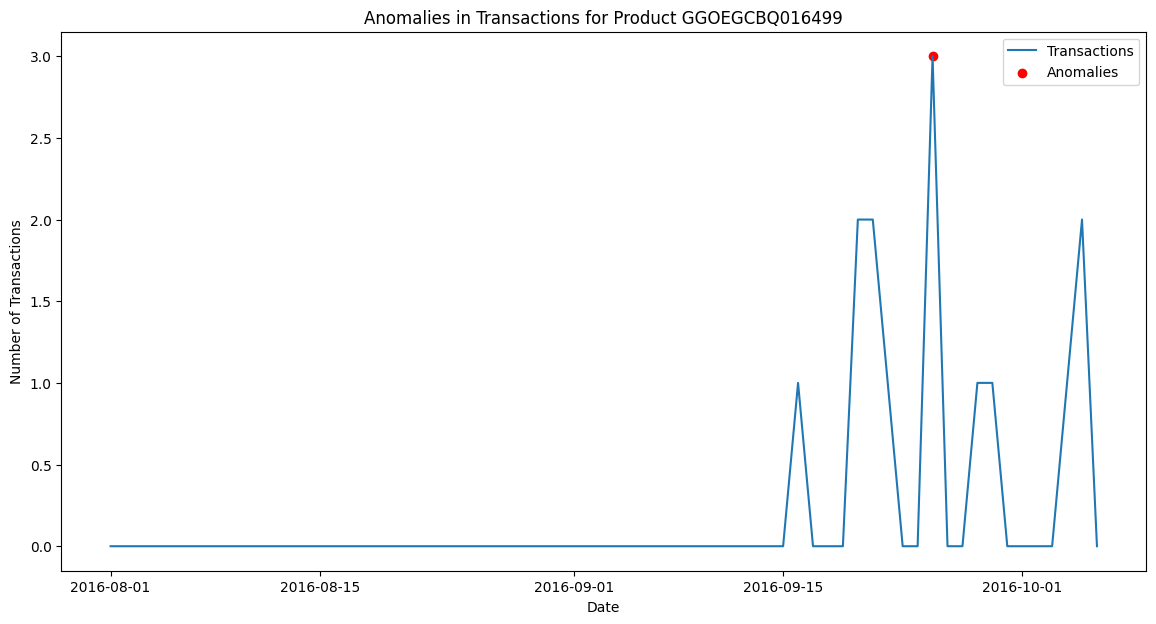

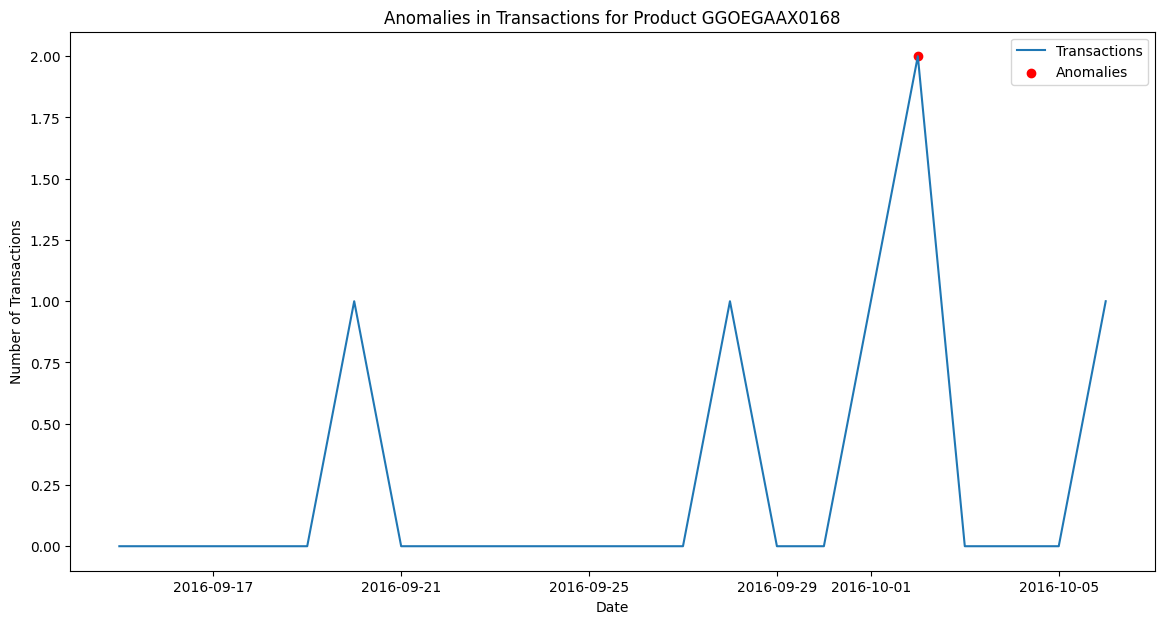

In [13]:
# Plotting transaction anomalies
for sku in anomalies['productSKU'].unique():
    product_anomalies = anomalies[anomalies['productSKU'] == sku]
    product_data = product_transactions[product_transactions['productSKU'] == sku]

    plt.figure(figsize=(14, 7))
    plt.plot(product_data['DateTime'], product_data['transactions'], label='Transactions')
    plt.scatter(product_anomalies['DateTime'], product_anomalies['transactions'], color='red', label='Anomalies')
    plt.title(f'Anomalies in Transactions for Product {sku}')
    plt.xlabel('Date')
    plt.ylabel('Number of Transactions')
    plt.legend()
    plt.show()